# Forecasting pipeline
## TASK 9
### Importing data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

try:
    from prophet import Prophet
except ImportError:
    from fbprophet import Prophet



### Functions

In [5]:
def preprocess_hourly(df: pd.DataFrame) -> pd.DataFrame:
    # sort → datetime index → tz-naive → hourly grid → interpolate numeric
    df = df.sort_values("timestamp").set_index("timestamp")
    try:
        df.index = df.index.tz_convert(None)
    except Exception:
        df.index = df.index.tz_localize(None)

    df = df.resample("h").asfreq()

    for c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            df[c] = df[c].interpolate(method="time").ffill().bfill()

    df.index.freq = "h"
    return df

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def metrics_dict(y_true, y_pred):
    return {
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE_%": mean_absolute_percentage_error(y_true, y_pred) * 100
    }


### Load data

In [6]:
train_raw = pd.read_csv("train_253253.csv", parse_dates=["timestamp"])
fcst_raw  = pd.read_csv("forecast.csv",      parse_dates=["timestamp"])

train = preprocess_hourly(train_raw)
fcst  = preprocess_hourly(fcst_raw)

train.head()


,pv_mod1,pv_mod2,pv_mod3,Demand,pv,Price,Temperature,Pressure (hPa),Cloud_cover (%),Cloud_cover_low (%),Cloud_cover_mid (%),Cloud_cover_high (%),Wind_speed_10m (km/h),Shortwave_radiation (W/m²),direct_radiation (W/m²),diffuse_radiation (W/m²),direct_normal_irradiance (W/m²),daymax
timestamp,,,,,,,,,,,,,,,,,,
2013-07-01 00:00:00,0.0,0.0,0.0,0.27,0.0,0.01605,13.5,1011.3,4.0,0.0,0.0,3.0,10.5,270.0,0.0,0.0,0.0,3.56
2013-07-01 01:00:00,0.0,0.0,0.0,0.23,0.0,0.00095,13.2,1010.8,27.0,1.0,2.0,23.0,11.9,270.0,0.0,0.0,0.0,3.56
2013-07-01 02:00:00,0.0,0.0,0.0,0.26,0.0,0.00060,13.1,1010.3,33.0,0.0,0.0,32.0,11.6,270.0,0.0,0.0,0.0,3.56
2013-07-01 03:00:00,0.0,0.0,0.0,0.28,0.0,0.00046,13.0,1010.3,28.0,0.0,0.0,27.0,11.2,270.0,2.0,7.0,30.1,3.56
2013-07-01 04:00:00,0.0,0.0,0.0,0.29,0.0,0.00046,13.8,1010.2,16.0,0.0,1.0,14.0,11.7,270.0,30.0,31.0,252.0,3.56


### Rolling setup (7 days)

In [9]:
start_day = fcst.index.min().normalize()
day_starts = [start_day + pd.Timedelta(days=i) for i in range(7)]
day_starts

[Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-07-02 00:00:00'),
 Timestamp('2014-07-03 00:00:00'),
 Timestamp('2014-07-04 00:00:00'),
 Timestamp('2014-07-05 00:00:00'),
 Timestamp('2014-07-06 00:00:00'),
 Timestamp('2014-07-07 00:00:00')]

### Build rolling windows + baselines (week-ago naive + drift)

In [10]:
windows = {}

for day_start in day_starts:
    day_end = day_start + pd.Timedelta(hours=24)

    # 0h lead-time history: train + forecast hours strictly before day_start
    hist = pd.concat([train, fcst.loc[:day_start - pd.Timedelta(hours=1)]], axis=0)

    # 24h block to forecast (true Demand exists in forecast.csv for evaluation)
    block = fcst.loc[day_start:day_end - pd.Timedelta(hours=1)].copy()
    y_true = block["Demand"].values

    # Baseline 1: seasonal naive (week-ago)
    tmp_d = pd.concat([hist["Demand"], pd.Series(index=block.index, dtype=float)], axis=0)
    naive_week_pred = tmp_d.shift(24*7).reindex(block.index).values

    # Baseline 2: drift (linear extrapolation from history)
    y_hist = hist["Demand"].dropna()
    y0, yT = y_hist.iloc[0], y_hist.iloc[-1]
    T = len(y_hist) - 1
    if T <= 0:
        drift_pred = np.repeat(yT, len(block))
    else:
        slope = (yT - y0) / T
        h = np.arange(1, len(block) + 1)
        drift_pred = yT + slope * h

    windows[day_start] = {
        "hist": hist,
        "block": block,
        "y_true": y_true,
        "naive_week_pred": naive_week_pred,
        "drift_pred": drift_pred
    }

# show what training is based on (first day)
d0 = day_starts[0]
print("DAY:", d0.date())
print("TRAIN(hist):", windows[d0]["hist"].index.min(), "->", windows[d0]["hist"].index.max(), "| rows:", len(windows[d0]["hist"]))
print("TEST(block):", windows[d0]["block"].index.min(), "->", windows[d0]["block"].index.max(), "| rows:", len(windows[d0]["block"]))


DAY: 2014-07-01
TRAIN(hist): 2013-07-01 00:00:00 -> 2014-06-30 23:00:00 | rows: 8760
TEST(block): 2014-07-01 00:00:00 -> 2014-07-01 23:00:00 | rows: 24


In [10]:
windows = {}

for day_start in day_starts:
    day_end = day_start + pd.Timedelta(hours=24)

    # 0h lead-time history: train + forecast hours strictly before day_start
    hist = pd.concat([train, fcst.loc[:day_start - pd.Timedelta(hours=1)]], axis=0)

    # 24h block to forecast (true Demand exists in forecast.csv for evaluation)
    block = fcst.loc[day_start:day_end - pd.Timedelta(hours=1)].copy()
    y_true = block["Demand"].values

    # Baseline 1: seasonal naive (week-ago)
    tmp_d = pd.concat([hist["Demand"], pd.Series(index=block.index, dtype=float)], axis=0)
    naive_week_pred = tmp_d.shift(24*7).reindex(block.index).values

    # Baseline 2: drift (linear extrapolation from history)
    y_hist = hist["Demand"].dropna()
    y0, yT = y_hist.iloc[0], y_hist.iloc[-1]
    T = len(y_hist) - 1
    if T <= 0:
        drift_pred = np.repeat(yT, len(block))
    else:
        slope = (yT - y0) / T
        h = np.arange(1, len(block) + 1)
        drift_pred = yT + slope * h

    windows[day_start] = {
        "hist": hist,
        "block": block,
        "y_true": y_true,
        "naive_week_pred": naive_week_pred,
        "drift_pred": drift_pred
    }

# show what training is based on (first day)
d0 = day_starts[0]
print("DAY:", d0.date())
print("TRAIN(hist):", windows[d0]["hist"].index.min(), "->", windows[d0]["hist"].index.max(), "| rows:", len(windows[d0]["hist"]))
print("TEST(block):", windows[d0]["block"].index.min(), "->", windows[d0]["block"].index.max(), "| rows:", len(windows[d0]["block"]))


DAY: 2014-07-01
TRAIN(hist): 2013-07-01 00:00:00 -> 2014-06-30 23:00:00 | rows: 8760
TEST(block): 2014-07-01 00:00:00 -> 2014-07-01 23:00:00 | rows: 24


In [10]:
windows = {}

for day_start in day_starts:
    day_end = day_start + pd.Timedelta(hours=24)

    # 0h lead-time history: train + forecast hours strictly before day_start
    hist = pd.concat([train, fcst.loc[:day_start - pd.Timedelta(hours=1)]], axis=0)

    # 24h block to forecast (true Demand exists in forecast.csv for evaluation)
    block = fcst.loc[day_start:day_end - pd.Timedelta(hours=1)].copy()
    y_true = block["Demand"].values

    # Baseline 1: seasonal naive (week-ago)
    tmp_d = pd.concat([hist["Demand"], pd.Series(index=block.index, dtype=float)], axis=0)
    naive_week_pred = tmp_d.shift(24*7).reindex(block.index).values

    # Baseline 2: drift (linear extrapolation from history)
    y_hist = hist["Demand"].dropna()
    y0, yT = y_hist.iloc[0], y_hist.iloc[-1]
    T = len(y_hist) - 1
    if T <= 0:
        drift_pred = np.repeat(yT, len(block))
    else:
        slope = (yT - y0) / T
        h = np.arange(1, len(block) + 1)
        drift_pred = yT + slope * h

    windows[day_start] = {
        "hist": hist,
        "block": block,
        "y_true": y_true,
        "naive_week_pred": naive_week_pred,
        "drift_pred": drift_pred
    }

# show what training is based on (first day)
d0 = day_starts[0]
print("DAY:", d0.date())
print("TRAIN(hist):", windows[d0]["hist"].index.min(), "->", windows[d0]["hist"].index.max(), "| rows:", len(windows[d0]["hist"]))
print("TEST(block):", windows[d0]["block"].index.min(), "->", windows[d0]["block"].index.max(), "| rows:", len(windows[d0]["block"]))


DAY: 2014-07-01
TRAIN(hist): 2013-07-01 00:00:00 -> 2014-06-30 23:00:00 | rows: 8760
TEST(block): 2014-07-01 00:00:00 -> 2014-07-01 23:00:00 | rows: 24


### Fit models first (per day): Prophet + ARIMA(4,0,1)

In [11]:
models = {"Prophet": {}, "ARIMA": {}}

for day_start in day_starts:
    hist = windows[day_start]["hist"]

    # Prophet = direct/one-shot multi-horizon forecast
    prop_train = hist[["Demand"]].reset_index()
    prop_train.columns = ["ds", "y"]
    m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
    m.add_country_holidays(country_name="EE")
    m.fit(prop_train)
    models["Prophet"][day_start] = m

    # ARIMA = recursive multi-step via forecast(24) on stationarised residuals
    dec = seasonal_decompose(hist["Demand"], model="additive", period=24, extrapolate_trend="freq")
    trend, seasonal, resid = dec.trend, dec.seasonal, dec.resid

    y_stat = np.log1p(resid.dropna())
    ar = ARIMA(y_stat, order=(4,0,1)).fit()

    models["ARIMA"][day_start] = {
        "model": ar,
        "trend_last": trend.dropna().iloc[-1],
        "seasonal_by_hour": seasonal.groupby(seasonal.index.hour).mean()
    }

print({k: len(v) for k, v in models.items()})


20:00:12 - cmdstanpy - INFO - Chain [1] start processing
20:00:13 - cmdstanpy - INFO - Chain [1] done processing
20:00:22 - cmdstanpy - INFO - Chain [1] start processing
20:00:23 - cmdstanpy - INFO - Chain [1] done processing
20:00:30 - cmdstanpy - INFO - Chain [1] start processing
20:00:30 - cmdstanpy - INFO - Chain [1] done processing
20:00:38 - cmdstanpy - INFO - Chain [1] start processing
20:00:39 - cmdstanpy - INFO - Chain [1] done processing
20:00:48 - cmdstanpy - INFO - Chain [1] start processing
20:00:49 - cmdstanpy - INFO - Chain [1] done processing
20:00:58 - cmdstanpy - INFO - Chain [1] start processing
20:00:59 - cmdstanpy - INFO - Chain [1] done processing
20:01:09 - cmdstanpy - INFO - Chain [1] start processing
20:01:09 - cmdstanpy - INFO - Chain [1] done processing


{'Prophet': 7, 'ARIMA': 7}


### Forecast 7 days + metrics table

In [13]:
pred_series = {"Actual": [], "NaiveWeek": [], "Drift": [], "Prophet": [], "ARIMA": []}
rows = []

for day_start in day_starts:
    block = windows[day_start]["block"]
    idx = block.index
    y_true = windows[day_start]["y_true"]

    # baselines
    naive_pred = windows[day_start]["naive_week_pred"]
    drift_pred = windows[day_start]["drift_pred"]

    # Prophet
    m = models["Prophet"][day_start]
    future = pd.DataFrame({"ds": idx})
    prophet_pred = m.predict(future)["yhat"].values

    # ARIMA restore
    pack = models["ARIMA"][day_start]
    ar = pack["model"]
    yhat_stat = ar.forecast(steps=24).values
    resid_hat = np.expm1(yhat_stat)
    seasonal_future = np.array([pack["seasonal_by_hour"][h] for h in idx.hour])
    arima_pred = resid_hat + pack["trend_last"] + seasonal_future

    # store for plots
    pred_series["Actual"].append(pd.Series(y_true, index=idx))
    pred_series["NaiveWeek"].append(pd.Series(naive_pred, index=idx))
    pred_series["Drift"].append(pd.Series(drift_pred, index=idx))
    pred_series["Prophet"].append(pd.Series(prophet_pred, index=idx))
    pred_series["ARIMA"].append(pd.Series(arima_pred, index=idx))

    # per-day metrics
    r = {"day": day_start.date()}
    r.update({f"NaiveWeek_{k}": v for k, v in metrics_dict(y_true, naive_pred).items()})
    r.update({f"Drift_{k}": v for k, v in metrics_dict(y_true, drift_pred).items()})
    r.update({f"Prophet_{k}": v for k, v in metrics_dict(y_true, prophet_pred).items()})
    r.update({f"ARIMA_{k}": v for k, v in metrics_dict(y_true, arima_pred).items()})
    rows.append(r)

results = pd.DataFrame(rows)
results


,day,NaiveWeek_RMSE,NaiveWeek_MAE,NaiveWeek_MAPE_%,Drift_RMSE,Drift_MAE,Drift_MAPE_%,Prophet_RMSE,Prophet_MAE,Prophet_MAPE_%,ARIMA_RMSE,ARIMA_MAE,ARIMA_MAPE_%
0,2014-07-01,0.431040,0.254583,48.256298,0.420334,0.232061,32.082844,0.358622,0.192773,32.442090,0.361810,0.261310,58.503942
1,2014-07-02,0.258029,0.178750,32.539509,0.376996,0.217488,29.373715,0.311523,0.224850,43.146407,0.316518,0.248292,53.867327
2,2014-07-03,0.286102,0.209583,59.127131,0.041593,0.030808,8.335734,0.180216,0.164705,47.730366,0.181159,0.154861,44.793801
3,2014-07-04,0.738989,0.483750,140.344724,0.045837,0.037051,10.431155,0.182677,0.164730,48.557399,0.208284,0.161003,49.654651
4,2014-07-05,0.158074,0.110417,33.259617,0.028101,0.019982,5.816246,0.205517,0.181901,55.759566,0.137324,0.111200,34.227533
5,2014-07-06,0.208157,0.142917,41.881487,0.043166,0.033309,9.373773,0.155684,0.135663,41.763102,0.143217,0.115950,36.406846
6,2014-07-07,0.557016,0.350833,41.166839,0.553862,0.352442,38.595800,0.497658,0.324152,40.863852,0.550736,0.381067,49.102849


### Overall summary (mean over 7 days)

In [14]:
summary = pd.DataFrame({
    "Model": ["Naive (week-ago)", "Drift", "Prophet", "ARIMA(4,0,1)"],
    "RMSE_mean": [
        results["NaiveWeek_RMSE"].mean(),
        results["Drift_RMSE"].mean(),
        results["Prophet_RMSE"].mean(),
        results["ARIMA_RMSE"].mean(),
    ],
    "MAE_mean": [
        results["NaiveWeek_MAE"].mean(),
        results["Drift_MAE"].mean(),
        results["Prophet_MAE"].mean(),
        results["ARIMA_MAE"].mean(),
    ],
    "MAPE_mean_%": [
        results["NaiveWeek_MAPE_%"].mean(),
        results["Drift_MAPE_%"].mean(),
        results["Prophet_MAPE_%"].mean(),
        results["ARIMA_MAPE_%"].mean(),
    ],
})
summary


,Model,RMSE_mean,MAE_mean,MAPE_mean_%
0,Naive (week-ago),0.376772,0.247262,56.653658
1,Drift,0.215698,0.131877,19.144181
2,Prophet,0.270271,0.198396,44.323255
3,"ARIMA(4,0,1)",0.271292,0.204812,46.650993


### Plot all 7 days (one figure)

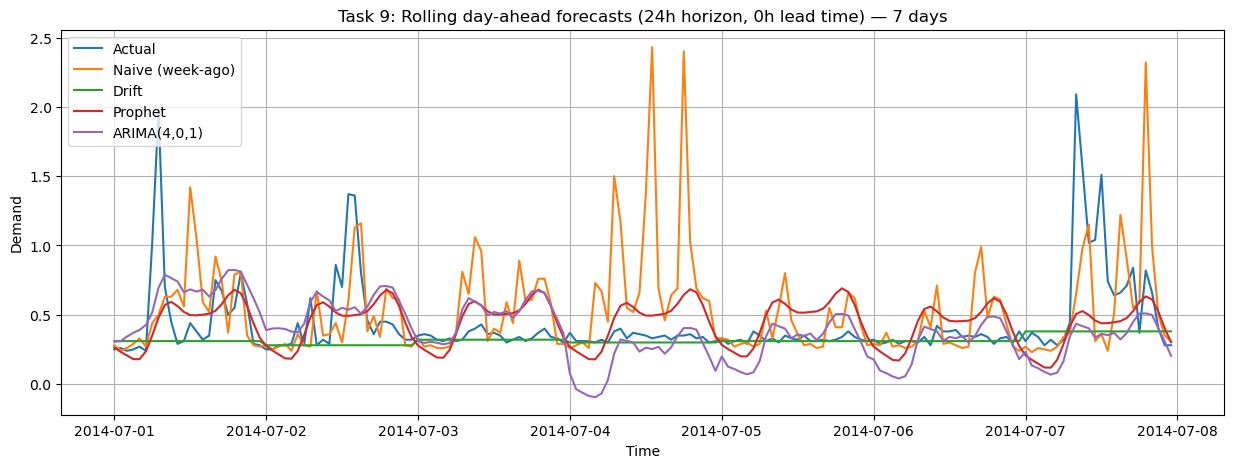

In [15]:
plot_df = pd.DataFrame({
    "Actual":    pd.concat(pred_series["Actual"]),
    "NaiveWeek": pd.concat(pred_series["NaiveWeek"]),
    "Drift":     pd.concat(pred_series["Drift"]),
    "Prophet":   pd.concat(pred_series["Prophet"]),
    "ARIMA":     pd.concat(pred_series["ARIMA"]),
})

plt.figure(figsize=(15,5))
plt.plot(plot_df.index, plot_df["Actual"], label="Actual")
plt.plot(plot_df.index, plot_df["NaiveWeek"], label="Naive (week-ago)")
plt.plot(plot_df.index, plot_df["Drift"], label="Drift")
plt.plot(plot_df.index, plot_df["Prophet"], label="Prophet")
plt.plot(plot_df.index, plot_df["ARIMA"], label="ARIMA(4,0,1)")
plt.grid(True)
plt.legend()
plt.title("Task 9: Rolling day-ahead forecasts (24h horizon, 0h lead time) — 7 days")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.show()


### Errors per day (line + bar)

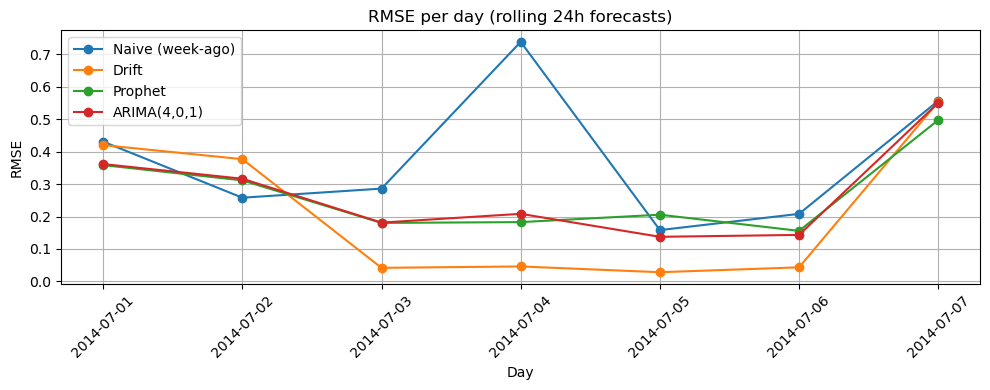

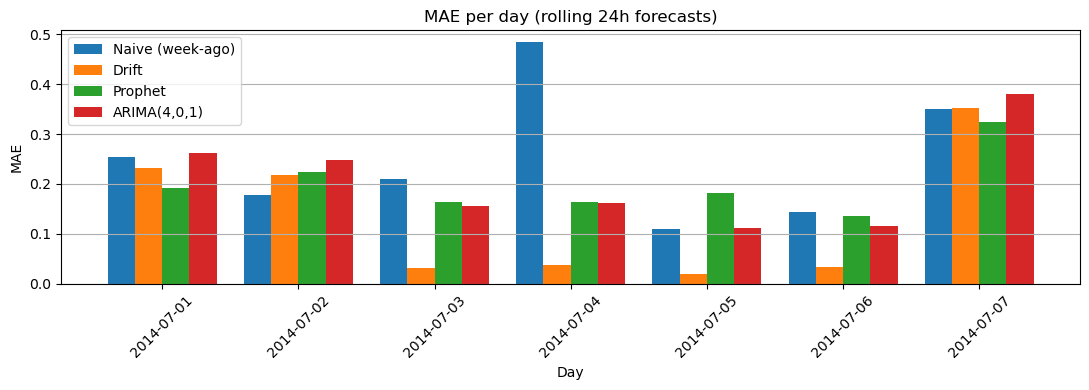

In [19]:
# Line plot: RMSE per day
plt.figure(figsize=(10,4))

plt.plot(results["day"], results["NaiveWeek_RMSE"], marker="o", label="Naive (week-ago)")
plt.plot(results["day"], results["Drift_RMSE"],     marker="o", label="Drift")
plt.plot(results["day"], results["Prophet_RMSE"],   marker="o", label="Prophet")
plt.plot(results["day"], results["ARIMA_RMSE"],     marker="o", label="ARIMA(4,0,1)")

plt.grid(True)
plt.legend()
plt.title("RMSE per day (rolling 24h forecasts)")
plt.xlabel("Day")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar plot: MAE per day (grouped bars)
plt.figure(figsize=(11,4))

x = np.arange(len(results))
w = 0.2

plt.bar(x - 1.5*w, results["NaiveWeek_MAE"], width=w, label="Naive (week-ago)")
plt.bar(x - 0.5*w, results["Drift_MAE"],     width=w, label="Drift")
plt.bar(x + 0.5*w, results["Prophet_MAE"],   width=w, label="Prophet")
plt.bar(x + 1.5*w, results["ARIMA_MAE"],     width=w, label="ARIMA(4,0,1)")

plt.grid(True, axis="y")
plt.legend()
plt.title("MAE per day (rolling 24h forecasts)")
plt.xlabel("Day")
plt.ylabel("MAE")
plt.xticks(x, [str(d) for d in results["day"]], rotation=45)
plt.tight_layout()
plt.show()
#MAPE per day t sometimes noisier due to low Demand values

### Heatmaps of errors (RMSE + MAE)

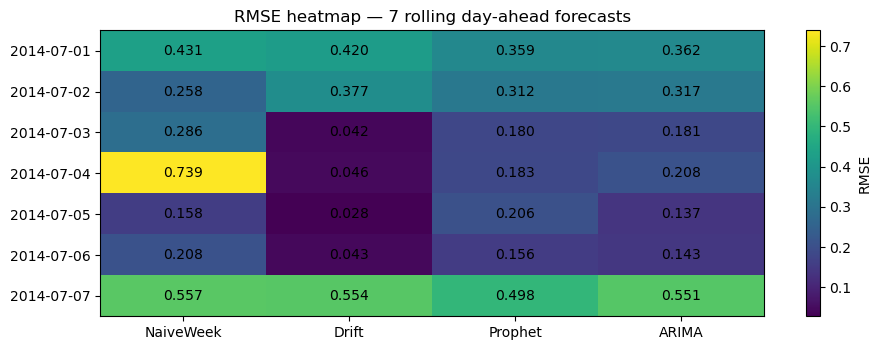

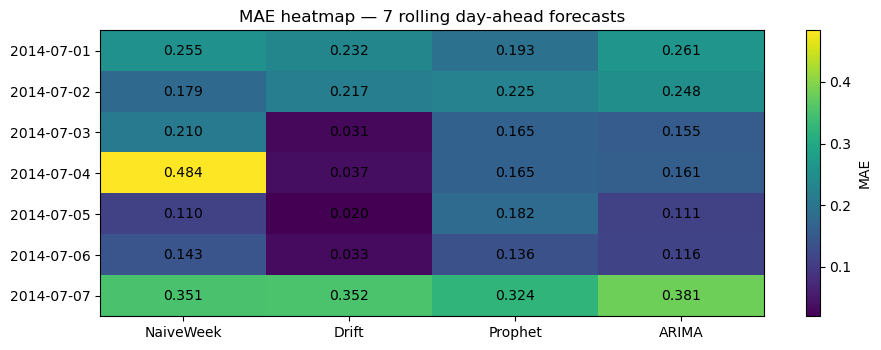

In [20]:
def plot_error_heatmap(results: pd.DataFrame, metric: str = "RMSE"):
    cols = {
        "NaiveWeek": f"NaiveWeek_{metric}",
        "Drift":     f"Drift_{metric}",
        "Prophet":   f"Prophet_{metric}",
        "ARIMA":     f"ARIMA_{metric}",
    }
    hm = results.set_index("day")[[cols[k] for k in cols]].copy()
    hm.columns = list(cols.keys())

    plt.figure(figsize=(9.5, 3.6))
    im = plt.imshow(hm.values, aspect="auto")
    plt.colorbar(im, label=metric)
    plt.xticks(range(hm.shape[1]), hm.columns)
    plt.yticks(range(hm.shape[0]), [str(d) for d in hm.index])

    for i in range(hm.shape[0]):
        for j in range(hm.shape[1]):
            plt.text(j, i, f"{hm.values[i, j]:.3f}", ha="center", va="center")

    plt.title(f"{metric} heatmap — 7 rolling day-ahead forecasts")
    plt.tight_layout()
    plt.show()

plot_error_heatmap(results, "RMSE")
plot_error_heatmap(results, "MAE")
